In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/datasets/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/datasets/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

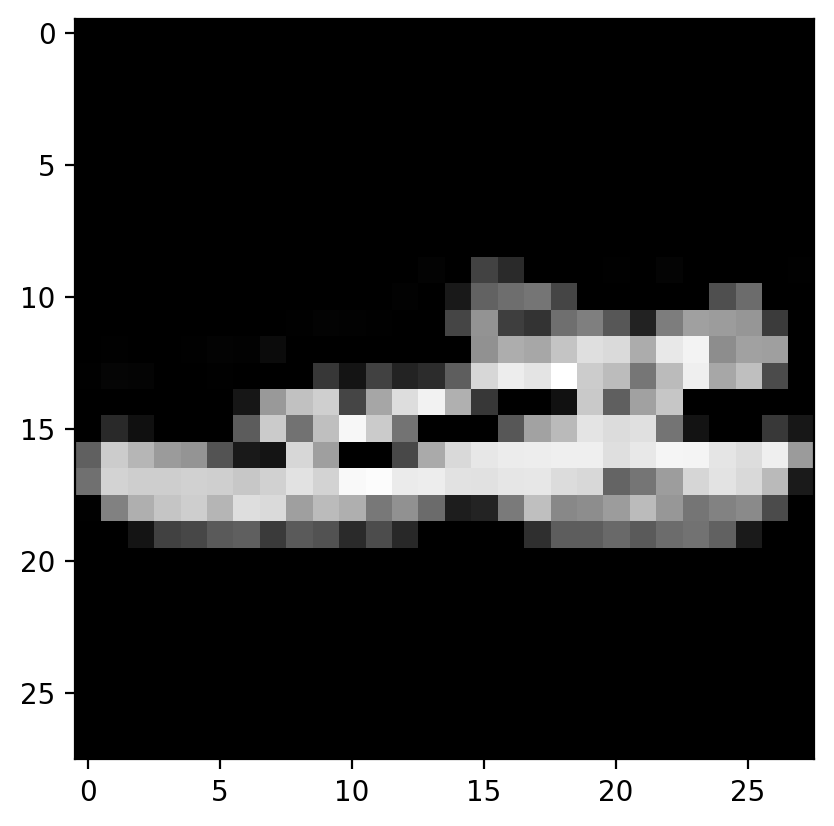

In [4]:
image, label = next(iter(trainloader))

plt.imshow(image[0].numpy().squeeze(), cmap='Greys_r')

In [5]:
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input layer
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
        
        '''
        super().__init__()
        # Input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        for each in self.hidden_layers:
            x = F.relu(each(x))
            x = self.dropout(x)
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)


def validation(model, testloader, criterion):
    accuracy = 0
    test_loss = 0
    for images, labels in testloader:

        images = images.resize_(images.size()[0], 784)

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ## Calculating the accuracy 
        # Model's output is log-softmax, take exponential to get the probabilities
        ps = torch.exp(output)
        # Class with highest probability is our predicted class, compare with true label
        equality = (labels.data == ps.max(1)[1])
        # Accuracy is number of correct predictions divided by all predictions, just take the mean
        accuracy += equality.type_as(torch.FloatTensor()).mean()

    return test_loss, accuracy

In [6]:
def train(model, trainloader, testloader, criterion, optimizer, epochs=5, print_every=40):
    
    steps = 0
    running_loss = 0
    for e in range(epochs):
        # Model in training mode, dropout is on
        model.train()
        for images, labels in trainloader:
            steps += 1
            
            # Flatten images into a 784 long vector
            images.resize_(images.size()[0], 784)
            
            optimizer.zero_grad()
            
            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            if steps % print_every == 0:
                # Model in inference mode, dropout is off
                model.eval()
                
                # Turn off gradients for validation, will speed up inference
                with torch.no_grad():
                    test_loss, accuracy = validation(model, testloader, criterion)
                
                print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                      "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                      "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
                
                running_loss = 0
                
                # Make sure dropout and grads are on for training
                model.train()

In [7]:
model = Network(784, 10, [516, 256], drop_p=0.5)

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model, trainloader, testloader, criterion, optimizer, epochs=2)

Epoch: 1/2..  Training Loss: 1.271..  Test Loss: 0.743..  Test Accuracy: 0.727
Epoch: 1/2..  Training Loss: 0.756..  Test Loss: 0.649..  Test Accuracy: 0.753
Epoch: 1/2..  Training Loss: 0.703..  Test Loss: 0.613..  Test Accuracy: 0.770
Epoch: 1/2..  Training Loss: 0.695..  Test Loss: 0.568..  Test Accuracy: 0.789
Epoch: 1/2..  Training Loss: 0.665..  Test Loss: 0.557..  Test Accuracy: 0.794
Epoch: 1/2..  Training Loss: 0.634..  Test Loss: 0.574..  Test Accuracy: 0.779
Epoch: 1/2..  Training Loss: 0.641..  Test Loss: 0.561..  Test Accuracy: 0.791
Epoch: 1/2..  Training Loss: 0.602..  Test Loss: 0.532..  Test Accuracy: 0.803
Epoch: 1/2..  Training Loss: 0.598..  Test Loss: 0.527..  Test Accuracy: 0.804
Epoch: 1/2..  Training Loss: 0.583..  Test Loss: 0.507..  Test Accuracy: 0.810
Epoch: 1/2..  Training Loss: 0.593..  Test Loss: 0.486..  Test Accuracy: 0.817
Epoch: 1/2..  Training Loss: 0.570..  Test Loss: 0.503..  Test Accuracy: 0.815
Epoch: 1/2..  Training Loss: 0.578..  Test Loss: 0.4

Saving Models

The parameters for PyTorch networks are stored in a model's state_dict. We can see the state dict contains the weight and bias matrices for each of our layer

In [8]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())


Our model: 

 Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=516, bias=True)
    (1): Linear(in_features=516, out_features=256, bias=True)
  )
  (output): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
) 

The state dict keys: 

 odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'output.weight', 'output.bias'])


In [9]:
torch.save(model.state_dict(), 'checkpoint.pth')

In [10]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'output.weight', 'output.bias'])


In [11]:
model.load_state_dict(state_dict)

<All keys matched successfully>

Loading the state dict works only if the model architecture is exactly the same as the checkpoint architecture. 

This means we need to rebuild the model exactly as it was when trained. Information about the model architecture needs to be saved in the checkpoint, along with the state dict. 